# Neural Network to predict DOTA2 winner

In [1]:
#Import libraries
import os
import pandas as pd
import tensorflow as tf
import neural_network
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras import models, layers
import numpy as np
from time import perf_counter
from keras import layers, models, regularizers, optimizers 
from keras.utils import to_categorical
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVR
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [2]:
PATH_TO_DATA = './'

#Read train data
df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'dota2Train.csv'),header=None)

#Shuffle train data
df_train_features = df_train_features.sample(frac=1, random_state=42)

#First column is the target
df_train_targets = df_train_features[df_train_features.columns[0]] 

#Remove target from train data
df_train_features = df_train_features.drop(df_train_features.columns[[0]], axis=1)

#Replace -1 to 0 due to binary classification target
df_train_targets[df_train_targets < 0] = 0

#Read test data
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'dota2Test.csv'),header=None)
df_test_targets = df_test_features[df_test_features.columns[0]] 
df_test_targets[df_test_targets < 0] = 0

#Shuffle test data
df_test_features = df_test_features.sample(frac=1, random_state=42)

#Remove target from test data
df_test_features = df_test_features.drop(df_test_features.columns[[0]], axis=1)

<AxesSubplot:>

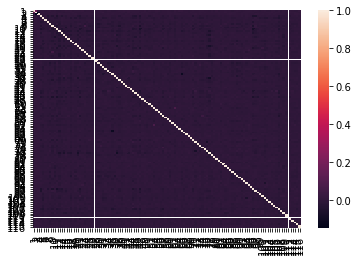

In [4]:
#Check correlation heatmap graph
corr = df_train_features.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values)

In [5]:
#Drop Null if any
df_train_features.dropna()
df_train_targets.dropna()
df_test_features.dropna()

,1,2,3,4,5,6,7,8,9,10,...,107,108,109,110,111,112,113,114,115,116
10099,155,2,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3000,152,2,2,0,0,0,0,0,1,-1,...,0,0,0,0,0,0,0,0,0,0
6885,152,9,2,0,1,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
10005,188,9,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3299,151,2,2,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,134,2,2,-1,0,0,0,0,0,0,...,-1,1,0,0,0,0,0,0,0,0
5191,135,2,2,0,0,0,0,0,0,-1,...,0,0,0,0,0,0,1,0,0,0
5390,182,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,156,2,2,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
#Set X,Y
X = df_train_features
y = df_train_targets.astype('int')
test = df_test_features

X1 = df_test_features
y1 = df_test_targets.astype('int')

In [8]:
#Further split to validation data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=123, shuffle=True, stratify=y)
X_test, X_valid1, y_test, y_valid1 = train_test_split(X1, y1, test_size=0.20, random_state=123, shuffle=True, stratify=y1)
X_train_orig = X_train
y_train_orig = y_train

In [9]:
#Let's see shapes
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape
X_test.shape, X_valid1.shape, y_test.shape, y_valid1.shape

((8235, 116), (2059, 116), (8235,), (2059,))

In [10]:
#Shuffle X_valid,y_valid
X_valid = X_valid.sample(frac=1, random_state=42)
y_valid = y_valid.sample(frac=1, random_state=42)

In [11]:
#Normalize train and test set
scaler = StandardScaler().fit(X_train)
scaler_test = StandardScaler().fit(X_test)

X_train = scaler.transform(X_train)
X_test = scaler_test.transform(X_test)
X_valid = scaler.transform(X_valid)  

# Neural Network Processing

In [12]:
#Define Model
model = Sequential()

#Add 2 hidden layers (+1 input)
model.add(layers.Input(shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(Dropout(0.1))

#Add output layer, sigmoid due to binary classification
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
#Some optimizers to work for
opt = SGD(lr=0.01)
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
earlystop = EarlyStopping(monitor="val_auc", patience=20, verbose=1, mode='max')
rms = tf.keras.optimizers.RMSprop(learning_rate=0.1)

In [14]:
#Compile Model
loss = 'binary_crossentropy'
model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])

In [15]:
#Fit Model
history = model.fit(X_train, y_train, validation_data = (X_valid,y_valid),epochs=10,batch_size=512)

Epoch 1/10
145/145 [==============================] - 2s 7ms/step - loss: 0.6889 - accuracy: 0.5576 - val_loss: 0.6679 - val_accuracy: 0.5944
Epoch 2/10
145/145 [==============================] - 0s 2ms/step - loss: 0.6642 - accuracy: 0.5978 - val_loss: 0.6671 - val_accuracy: 0.5914
Epoch 3/10
145/145 [==============================] - 0s 2ms/step - loss: 0.6626 - accuracy: 0.6024 - val_loss: 0.6659 - val_accuracy: 0.5938
Epoch 4/10
145/145 [==============================] - 0s 2ms/step - loss: 0.6608 - accuracy: 0.6040 - val_loss: 0.6670 - val_accuracy: 0.5903
Epoch 5/10
145/145 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.6029 - val_loss: 0.6673 - val_accuracy: 0.5902
Epoch 6/10
145/145 [==============================] - 0s 2ms/step - loss: 0.6574 - accuracy: 0.6126 - val_loss: 0.6688 - val_accuracy: 0.5861
Epoch 7/10
145/145 [==============================] - 0s 2ms/step - loss: 0.6570 - accuracy: 0.6083 - val_loss: 0.6686 - val_accuracy: 0.5880
Epoch 

In [16]:
#Predict accuracy
print(model.predict(X_valid,batch_size= 10))

Y_pred_nn = model.predict(X_valid)
rounded = [round(x[0]) for x in Y_pred_nn]
Y_pred_nn = rounded
score_nn = round(accuracy_score(Y_pred_nn,y_valid)*100,2)
print("The accuracy score achieved using Neural Network is: "+str(score_nn)+" %")

[[0.895632  ]
 [0.39168513]
 [0.50330216]
 ...
 [0.28581402]
 [0.376449  ]
 [0.31794724]]
The accuracy score achieved using Neural Network is: 59.0 %


In [17]:
#Get accuracy for test data so as to compare with the train one
#Define Model
model = Sequential()

#Add 2 hidden layers (+1 input)
model.add(layers.Input(shape=(X_test.shape[1],)))
model.add(BatchNormalization())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(Dropout(0.1))

#Add output layer, sigmoid due to binary classification
model.add(layers.Dense(1, activation='sigmoid'))

#Compile Model
loss = 'binary_crossentropy'
model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])

#Fit Model
history = model.fit(X_test, y_test, validation_data = (X_valid1,y_valid1),epochs=10,batch_size=512)

print(model.predict(X_valid1,batch_size= 10))

Y_pred_nn = model.predict(X_valid1)
rounded = [round(x[0]) for x in Y_pred_nn]
Y_pred_nn = rounded
score_nn = round(accuracy_score(Y_pred_nn,y_valid1)*100,2)
print("The accuracy score achieved using Neural Network is: "+str(score_nn)+" %")

Epoch 1/10
17/17 [==============================] - 1s 11ms/step - loss: 0.7552 - accuracy: 0.5032 - val_loss: 1.2624 - val_accuracy: 0.5347
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5390 - val_loss: 0.7186 - val_accuracy: 0.5347
Epoch 3/10
17/17 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5367 - val_loss: 0.6912 - val_accuracy: 0.5342
Epoch 4/10
17/17 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5516 - val_loss: 1.3054 - val_accuracy: 0.5347
Epoch 5/10
17/17 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5450 - val_loss: 3.5172 - val_accuracy: 0.5347
Epoch 6/10
17/17 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5434 - val_loss: 3.2493 - val_accuracy: 0.5347
Epoch 7/10
17/17 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5343 - val_loss: 5.4989 - val_accuracy: 0.5347
Epoch 8/10
17/17 [=

In [18]:
#Testing accuracy
score = model.evaluate(X_valid1, y_valid1)
print("\n Testing Accuracy:", score[1])

65/65 [==============================] - 0s 563us/step - loss: 6.1272 - accuracy: 0.5347

 Testing Accuracy: 0.5347256064414978


In [19]:
#Store history
history_dict = history.history
print('We have these parameters stored in our fitting history:')
history_dict.keys()

We have these parameters stored in our fitting history:


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

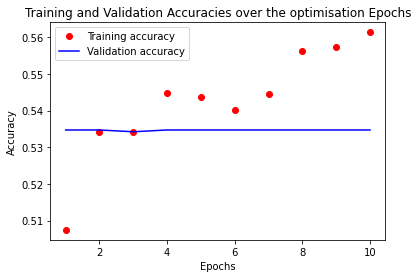

In [20]:
# Preparing some data for the plot:
accuracies = history_dict['accuracy']
val_accuracies = history_dict['val_accuracy']
epochs = range(1, len(accuracies)+1)

#Plot
plt.plot(epochs, accuracies, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracies over the optimisation Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
#The accurancy achieved by the neural network until now is 59%. I will apply a most generic approach in order to perform the execution of the model with different parameters, to check if we can get better results.

In [22]:
#Optimizers initialization set up 

LEARNING_RATE = 0.01
MOMENTUM = 0.9
RHO = 0.9
EPSILON = 1e-07


vanilla_sgd = optimizers.SGD(
    learning_rate=LEARNING_RATE
)
sgd_momentum = optimizers.SGD(
    learning_rate=LEARNING_RATE, momentum=MOMENTUM
)
sgd_nesterov = optimizers.SGD(
    learning_rate=LEARNING_RATE, momentum=MOMENTUM, nesterov=True
)
rmsprop = optimizers.RMSprop(
    learning_rate=LEARNING_RATE, rho=RHO, momentum=0.0, epsilon=EPSILON, centered=False
)
rmsprop_momentum = optimizers.RMSprop(
    learning_rate=LEARNING_RATE, rho=RHO, momentum=MOMENTUM, epsilon=EPSILON, centered=False
)
adam = optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=EPSILON, amsgrad=False
)
adadelta = optimizers.Adadelta(
    learning_rate=LEARNING_RATE, rho=RHO, epsilon=EPSILON
)
adagrad = optimizers.Adagrad(
    learning_rate=LEARNING_RATE, initial_accumulator_value=0.1, epsilon=EPSILON
)
adamax = optimizers.Adamax(
    learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=EPSILON
)
nadam = optimizers.Nadam(
    learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=EPSILON
)
ftrl = optimizers.Ftrl(
    learning_rate=0.01,
    learning_rate_power=-0.5,
    initial_accumulator_value=0.1,
    l1_regularization_strength=0.0,
    l2_regularization_strength=0.0,
    l2_shrinkage_regularization_strength=0.0,
)

optimisers = [vanilla_sgd, sgd_momentum, sgd_nesterov, rmsprop, rmsprop_momentum,
             adam, adadelta, adagrad, adamax, nadam, ftrl]

optimisers_names = [
    'Vanilla SGD', 'SGD Momentum', 'SGD Nesterov', 'RMSprop', 'RMSprop Momentum', 
    'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl'
]

optimisers = {
    name: optimiser for name, optimiser in zip(optimisers_names, optimisers)
}

In [23]:
#Function to create and compile a neural network model.
#Input are the hidden layers and passed in function
def create_model(optimiser,train_data,input_layers,input_loss='binary_crossentropy',input_metrics=['accuracy']):
    model = models.Sequential()
    model.add(layers.Input(shape=(train_data.shape[1],)))
    for key in input_layers:
        prefix = key.split("|",1)[0]
        unit = key.split("|",1)[1] 
        if (prefix != '0'):
            model.add(layers.Dense(unit, activation=input_layers[key], kernel_regularizer=regularizers.l2(0.01)))
        if (prefix == '0'):
            model.add(layers.Dense(unit, activation=input_layers[key]))
    
    model.compile(
        optimizer=optimiser, 
        loss=input_loss,
        metrics=input_metrics
    )
    return model

In [24]:
#Run model with different optimizers and print their accuracy
EPOCHS=50
MINI_BATCH=512
VALIDATION_PERC=0.2
histories = {}
loss = 'binary_crossentropy'
metrics = ['accuracy']
#1 is the first layer with 16 hidden units and activation function relu.0 is the output layer
input_layers = {'1|16':'relu', '2|16':'relu', '0|1':'sigmoid'}

for optimiser_name in optimisers:
    start = perf_counter()
    print('Fitting model with optimiser: ', optimiser_name)
    model = create_model(optimisers[optimiser_name],X_train,input_layers,loss,metrics)
    history = model.fit(X_train, y_train, 
                        epochs=EPOCHS, 
                        batch_size=MINI_BATCH, 
                        validation_split=VALIDATION_PERC, 
                        verbose=0
                       )
    print(' - Elapsed Time:', round(perf_counter()-start, 2),'seconds')
    histories[optimiser_name] = history.history
    score = model.evaluate(X_valid, y_valid)
    print("\n Testing Accuracy:", score[1])

Fitting model with optimiser:  Vanilla SGD
 - Elapsed Time: 6.84 seconds
580/580 [==============================] - 0s 499us/step - loss: 0.7162 - accuracy: 0.5914

 Testing Accuracy: 0.5913653373718262
Fitting model with optimiser:  SGD Momentum
 - Elapsed Time: 6.71 seconds
580/580 [==============================] - 0s 549us/step - loss: 0.6701 - accuracy: 0.5977

 Testing Accuracy: 0.5977333784103394
Fitting model with optimiser:  SGD Nesterov
 - Elapsed Time: 6.39 seconds
580/580 [==============================] - 0s 550us/step - loss: 0.6701 - accuracy: 0.5987

 Testing Accuracy: 0.5986508131027222
Fitting model with optimiser:  RMSprop
 - Elapsed Time: 7.29 seconds
580/580 [==============================] - 0s 536us/step - loss: 0.6735 - accuracy: 0.5894

 Testing Accuracy: 0.5893685817718506
Fitting model with optimiser:  RMSprop Momentum
 - Elapsed Time: 6.76 seconds
580/580 [==============================] - 0s 551us/step - loss: 0.6966 - accuracy: 0.5675

 Testing Accuracy: 0

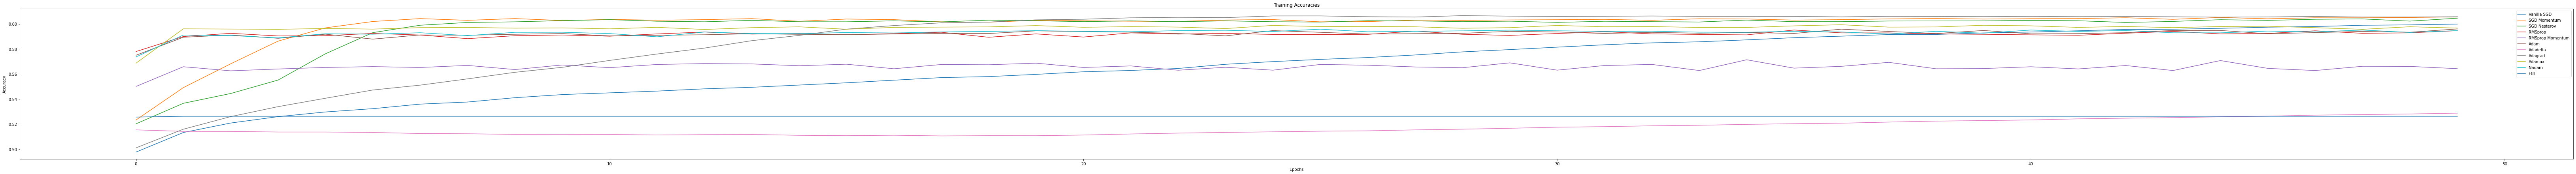

In [25]:
#Plot
epochs = range(0, EPOCHS)

plt.figure(figsize=(116, 7))
for h in histories:  
    plt.plot(epochs, histories[h]['accuracy'], label=h)
plt.title(f'Training Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
#Best results for this try are for optimizer Adagrad for the above parameters. Let's change them a little bit.

EPOCHS=100
MINI_BATCH=1024
VALIDATION_PERC=0.5
histories = {}
loss = 'binary_crossentropy'
metrics = ['accuracy']
#1 is the first layer with 16 hidden units and activation function relu.0 is the output layer
input_layers = {'1|512':'relu', '2|255':'relu','3|16':'relu', '0|1':'sigmoid'}

for optimiser_name in optimisers:
    start = perf_counter()
    print('Fitting model with optimiser: ', optimiser_name)
    model = create_model(optimisers[optimiser_name],X_train,input_layers,loss,metrics)
    history = model.fit(X_train, y_train, 
                        epochs=EPOCHS, 
                        batch_size=MINI_BATCH, 
                        validation_split=VALIDATION_PERC, 
                        verbose=0
                       )
    print(' - Elapsed Time:', round(perf_counter()-start, 2),'seconds')
    histories[optimiser_name] = history.history
    score = model.evaluate(X_valid, y_valid)
    print("\n Testing Accuracy:", score[1])

Fitting model with optimiser:  Vanilla SGD
 - Elapsed Time: 34.67 seconds
580/580 [==============================] - 0s 793us/step - loss: 1.9536 - accuracy: 0.5923

 Testing Accuracy: 0.5923367738723755
Fitting model with optimiser:  SGD Momentum
 - Elapsed Time: 35.97 seconds
580/580 [==============================] - 0s 798us/step - loss: 0.7243 - accuracy: 0.5835

 Testing Accuracy: 0.5835402011871338
Fitting model with optimiser:  SGD Nesterov
 - Elapsed Time: 34.7 seconds
580/580 [==============================] - 0s 772us/step - loss: 0.7151 - accuracy: 0.5857

 Testing Accuracy: 0.5856988430023193
Fitting model with optimiser:  RMSprop
 - Elapsed Time: 35.76 seconds
580/580 [==============================] - 0s 814us/step - loss: 0.7232 - accuracy: 0.5873

 Testing Accuracy: 0.5873178839683533
Fitting model with optimiser:  RMSprop Momentum
 - Elapsed Time: 35.43 seconds
580/580 [==============================] - 0s 782us/step - loss: 0.6918 - accuracy: 0.5265

 Testing Accurac

In [27]:
#Optimizers Adagrad,Adamax provide the best accuracy for our training data(59,48%).

# Regularization

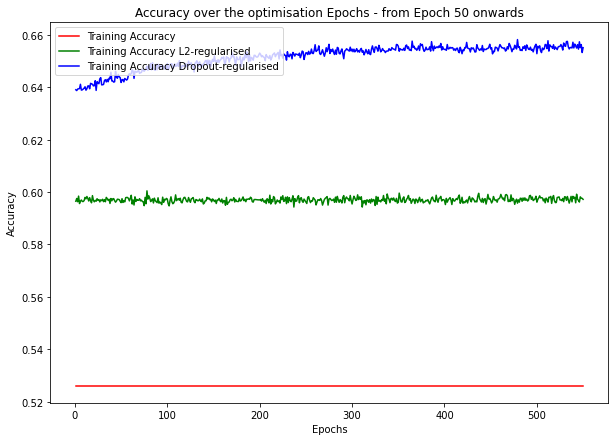

In [29]:
from keras import constraints, optimizers

SEED = 1000
NUM_EPOCHS = 600
START_PLOT_FROM_EPOCH=50

model_history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_split=0.2, verbose=0)

model_history = model_history.history
train_acc = model_history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc = model_history['val_accuracy'][START_PLOT_FROM_EPOCH:]
epochs = range(1, len(train_acc)+1)

model_regL2 = models.Sequential()
model_regL2.add(layers.Input(shape=(X_train.shape[1],)))
model_regL2.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_regL2.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_regL2.add(layers.Dense(1, activation='sigmoid'))
model_regL2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_regL2_history = model_regL2.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_split=0.2, verbose=0)

model_regDropout = models.Sequential()
model_regDropout.add(layers.Dropout(0.01, input_shape=(X_train.shape[1],), seed=SEED))
model_regDropout.add(layers.Dense(16, activation='relu'))
model_regDropout.add(layers.Dropout(0.01, seed=SEED))
model_regDropout.add(layers.Dense(16, activation='relu'))
model_regDropout.add(layers.Dropout(0.01, seed=SEED))
model_regDropout.add(layers.Dense(1, activation='sigmoid'))
model_regDropout.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
model_regDropout_history = model_regDropout.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_split=0.2, verbose=0)

model_regDropout_history = model_regDropout_history.history
train_acc_regDropout = model_regDropout_history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc_regDropout = model_regDropout_history['val_accuracy'][START_PLOT_FROM_EPOCH:]

model_regL2_history = model_regL2_history.history
train_acc_regL2 = model_regL2_history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc_regL2 = model_regL2_history['val_accuracy'][START_PLOT_FROM_EPOCH:]

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, train_acc_regL2, 'g', label='Training Accuracy L2-regularised')
plt.plot(epochs, train_acc_regDropout, 'b', label='Training Accuracy Dropout-regularised')
plt.title(f'Accuracy over the optimisation Epochs - from Epoch {START_PLOT_FROM_EPOCH} onwards')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Execute non Neural Network Classifiers

In [31]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 900, criterion = 'gini', random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_valid)
print(classifier.score(X_valid, y_valid))

0.5814894765245547


In [32]:
#SVM
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_predict = svc_model.predict(X_valid)

In [33]:
#Classification Report
print(classification_report(y_valid, y_predict))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53      8774
           1       0.60      0.67      0.63      9756

    accuracy                           0.59     18530
   macro avg       0.58      0.58      0.58     18530
weighted avg       0.58      0.59      0.58     18530



In [42]:
#Train Test Split
X_train_min = X_train.min()
X_train_min
X_train_max = X_train.max()
X_train_max
X_train_range = (X_train_max- X_train_min)
X_train_range
X_train_scaled = (X_train - X_train_min)/(X_train_range)
X_test_min = X_test.min()
X_test_range = (X_test - X_test_min).max()
X_test_scaled = (X_test - X_test_min)/X_test_range

In [41]:
svc_model = SVC()
svc_model.fit(X_train_scaled, y_train)
y_predict = svc_model.predict(X_test_scaled)

# Cross Validation

In [43]:
#Random Forest
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

model = RandomForestClassifier()

model_name = type(model).__name__
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print(cv_results)
cv_results = cross_validate(model, X_train, y_train, cv=10)
print(cv_results)
cv_predictions = cross_val_predict(model, X_train, y_train, cv=10)
print(cv_predictions)
cv_f1_score = f1_score(y_train, cv_predictions, average='weighted')

print()
print(model_name + ' * f1_score =', round(cv_f1_score, 4))



[0.58135456 0.56921209 0.57582299 0.56975175 0.57271991 0.5907987
 0.56799784 0.57973556 0.57568807 0.57245008]
{'fit_time': array([20.47500324, 21.06499839, 21.71100235, 20.92900229, 20.78900027,
       22.40799713, 22.23003197, 21.31099701, 20.69299912, 21.38199639]), 'score_time': array([0.31899929, 0.34999871, 0.32596445, 0.32296753, 0.33899736,
       0.38698435, 0.32400227, 0.33696866, 0.32797098, 0.32499743]), 'test_score': array([0.5701565 , 0.57771182, 0.58270372, 0.56651376, 0.56543443,
       0.57474366, 0.58243389, 0.5701565 , 0.58027523, 0.56826767])}
[1 1 1 ... 1 1 1]

RandomForestClassifier * f1_score = 0.5721


In [46]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)

model_name = type(model).__name__
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print(cv_results)
cv_results = cross_validate(model, X_train, y_train, cv=10)
print(cv_results)
cv_predictions = cross_val_predict(model, X_train, y_train, cv=10)
print(cv_predictions)
cv_f1_score = f1_score(y_train, cv_predictions, average='weighted')

print()
print(model_name + ' * f1_score =', round(cv_f1_score, 4))

[0.53818133 0.52441986 0.52630869 0.53170534 0.52253103 0.52280086
 0.53453859 0.5264436  0.53359417 0.52657852]
{'fit_time': array([12.53700113, 12.41840005, 12.72202778, 12.52303362, 12.47100163,
       12.47296572, 12.39019942, 12.54103827, 12.4740324 , 12.50200105]), 'score_time': array([96.06599951, 95.94296551, 96.0699687 , 96.16996646, 96.08703208,
       96.23899913, 96.41900754, 95.93996167, 96.64899969, 96.01496792]), 'test_score': array([0.53818133, 0.52441986, 0.52630869, 0.53170534, 0.52253103,
       0.52280086, 0.53453859, 0.5264436 , 0.53359417, 0.52657852])}
[0 1 0 ... 1 0 0]

KNeighborsClassifier * f1_score = 0.5277


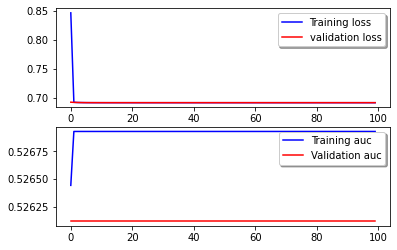

In [40]:
# Plot the loss and accuracy curves for training and validation 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training auc")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation auc")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
#The accuracy of the train data is almost similar to the accuracy of the test data.The selected non neural network classifiers perform almost the same results with our neural network, but in much more time.